In [51]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch.utils.data import DataLoader, Dataset

import torch.nn.init as init

import pysindy as ps
from sklearn.decomposition import PCA

import sys

sys.path.append('../src')
from read_dataset import data_from_name
from model import *
from tools import *
from train import *

import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
b = 24
alpha = 1.5
lags = 9
freq = 10
scale=0.25
Burgess= False

In [57]:
steps = 1

#******************************************************************************
# load data
#******************************************************************************
X, Xclean, m, n = data_from_name("climate", freq=1, start_year=1900, end_year= 2010, tropical=0, scale=scale)

print(type(X))
#******************************************************************************
# Reshape data for pytorch into 4D tensor Samples x Channels x Width x Height
#******************************************************************************
X = add_channels(X)


# transfer to tensor
X = torch.from_numpy(X).float().contiguous()


mean = torch.mean(X,dim=0)
# mean = torch.mean(X)
print(mean.shape)
std = torch.std(X)
print(std)
X = (X-mean)/ (std+1e-7) 
# Add lags

catDat = []
start = 0
for i in np.arange(lags-1,-1, -1):
    if i == 0:
        catDat.append(X[start*freq:].float())
    else:
        catDat.append(X[start*freq:-i*freq].float())
    start += 1
X = torch.cat(catDat,dim=2)
del(catDat)
print(X.shape)

#******************************************************************************
# Create Dataloader objects
#******************************************************************************
trainDat = []
start = 0
for i in np.arange(steps,-1, -1):
    if i == 0:
        trainDat.append(X[start*freq:].float())
    else:
        trainDat.append(X[start*freq:-i*freq].float())
    start += 1

train_data = torch.utils.data.TensorDataset(*trainDat)
del(trainDat)

# train_loader = DataLoader(dataset = train_data,
#                               batch_size = 64,
#                               shuffle = True)

<class 'numpy.ndarray'>
(40178, 18, 36)
<class 'numpy.ndarray'>
torch.Size([1, 18, 36])
tensor(20.8373)
torch.Size([40098, 1, 162, 36])


In [58]:
# model_path = "results_climate/model_backward0.pkl"
model_path = "results_climate/model22.pkl"
# m, n, b, steps, steps_back =
model = koopmanAE(m, n, lags, b, steps=12, steps_back=0, alpha=alpha, Burgess=Burgess)
model.load_state_dict(torch.load(model_path))
model.eval()

koopmanAE(
  (encoder): encoderNet(
    (act): ReLU()
    (batch1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=5832, out_features=192, bias=True)
    (fc2): Linear(in_features=192, out_features=96, bias=True)
    (fc3): Linear(in_features=96, out_features=48, bias=True)
    (fc4): Linear(in_features=48, out_features=24, bias=True)
    (fc5): Linear(in_features=24, out_features=24, bias=True)
  )
  (decoder): decoderNet(
    (act): ReLU()
    (fc1): Linear(in_features=24, out_features=24, bias=True)
    (fc2): Linear(in_features=24, out_features=48, bias=True)
    (fc3): Linear(in_features=48, out_features=96, bias=True)
    (fc4): Linear(in_features=96, out_features=192, bias=True)
    (fc5): Linear(in_features=192, out_features=5832, bias=True)
  )
  (dynamics): dynamics(
    (dynamics): Linear(in_features=24, out_features=24, bias=False)
  )
  (backdynamics): dynamics_back(
    (dynamics): Linear(in_features=24, out_fe

In [59]:
# del(train_loader)
with torch.no_grad():
    embedding= (model.encoder(train_data[:][0]))

embedding = np.reshape(embedding, newshape= (-1,b))
# del(train_data)

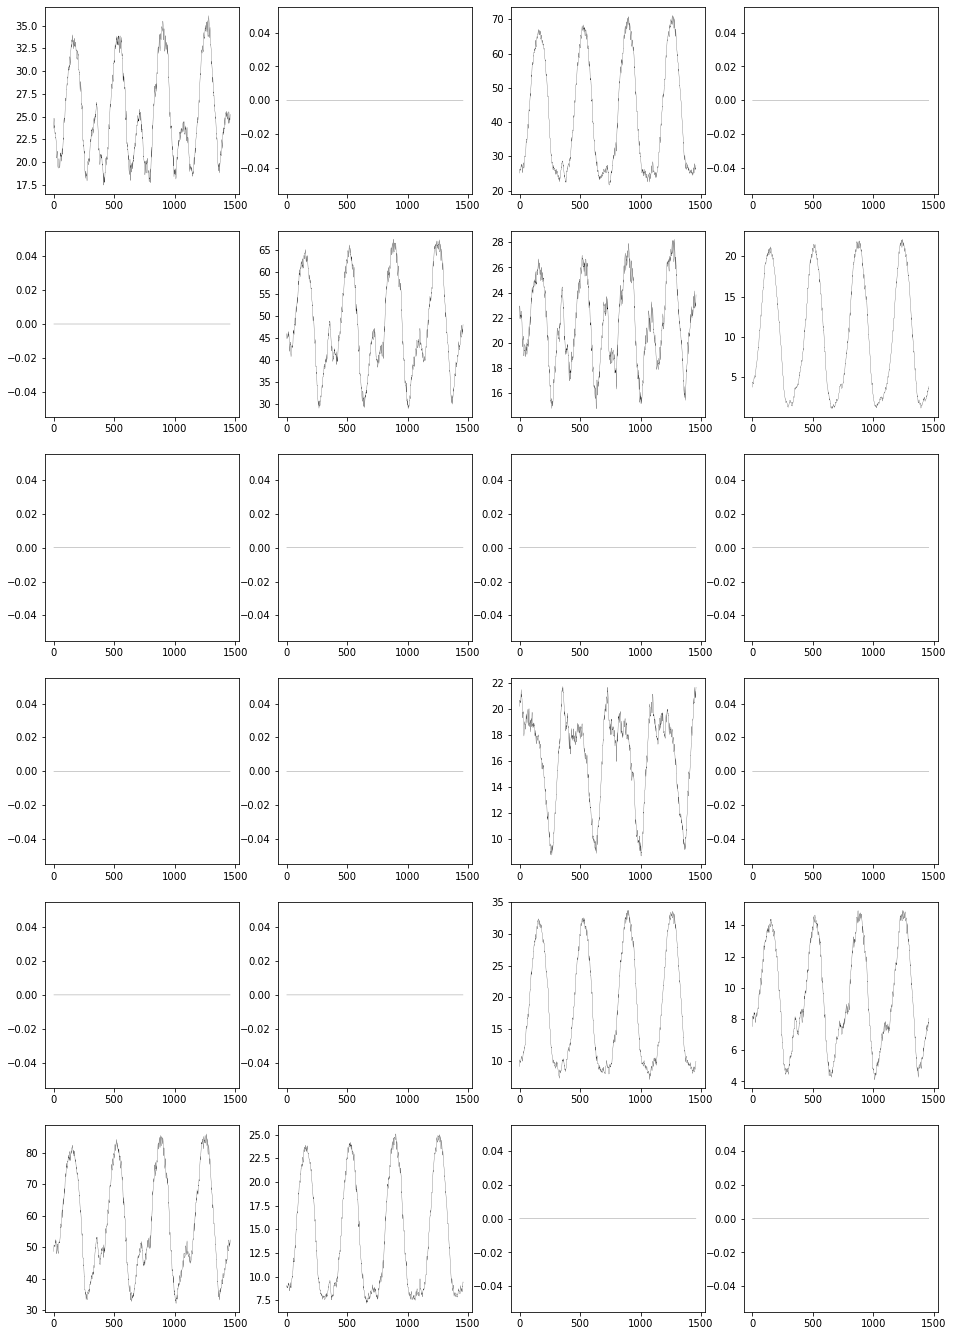

In [60]:
# to_plot= projected[:4*365]
to_plot= embedding[:4*365]

fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
for i in range(b):
#     print(i%3, int(i/4))
    ax[int(i/4), i%4].plot(to_plot[:,i], 'k', linewidth=.2)

In [61]:
non_zero = np.var(np.array(embedding),axis=0)>0.1

In [62]:
X = np.array(embedding[:,non_zero])

In [48]:
print(X.shape)

(39998, 44)


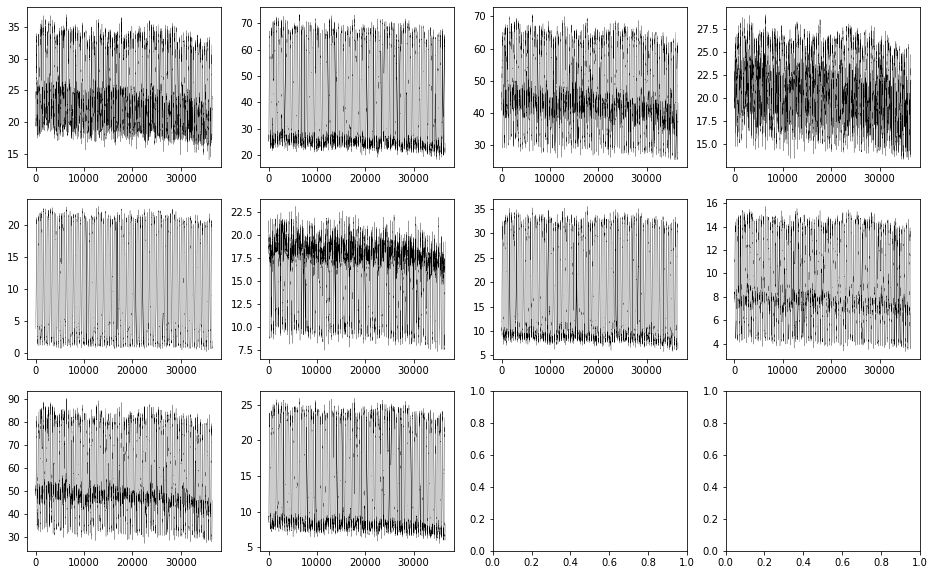

In [64]:
to_plot = X[:365*100]
b= X.shape[1]

fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
for i in range(b):
#     print(i%3, int(i/4))
    ax[int(i/4), i%4].plot(to_plot[:,i], 'k', linewidth=.2)

In [65]:
pca = PCA(n_components='mle')
pca.fit(X)


PCA(n_components='mle')

In [14]:
print(pca.n_components_)

4


In [15]:
print(pca.explained_variance_)

[56.629295    1.3344777   0.68778795  0.37085503]


In [66]:
X_red=pca.transform(X)

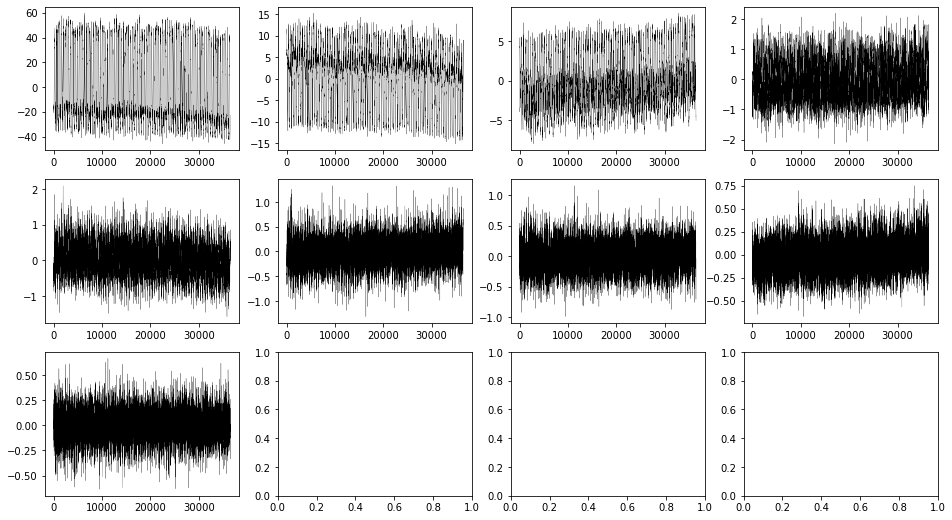

In [70]:
to_plot = X_red[:365*100]
b= to_plot.shape[1]

fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
for i in range(b):
    ax[int(i/4), i%4].plot(to_plot[:,i], 'k', linewidth=.2)
    # ax[i%4].plot(to_plot[:,i], 'k', linewidth=.2)

In [19]:
model = ps.SINDy()
model.fit(X_red)
model.print()

x0' = 0.000
x1' = 0.000
x2' = 0.000
x3' = 0.000
/home/youssef/anaconda3/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:163: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
